# Feature Engineering and Selection

## Table of Contents
* [1.Import cleaned Data](#import_data)
* [2.Feature Engineering](#feat_eng)
    * [2.1  `order_week_day`](#order_weekday)
    * [2.2 `delivery_days`](#delivery_days)
    * [2.2 User specific features](#user_feat)
        * [ 3.2.1 `user_account_age`](#user_account_age)
        * [ 3.2.2 `user_age`](#user_age)
        * [ 3.2.2 `total_orders_by_user`](#total_orders_by_user)
        * [ 3.2.2 `has_bought_item_before`](#has_bought_item_before)
        * [ 3.2.2 `is_first_purchase`](#is_first_purchase)
        * [ 3.2.2 `number_of_items_in_order`](#number_of_items_in_order)
        * [ 3.2.2 `ordered_item_multiple_times_in_order`](#ordered_item_multiple_times_in_order)
* [3.Feature Selection](#feat_select)
    * [3.1  Unify `item_id` and `brand_id` Category Levels ](#unify)
    * [3.2  Binning ](#binning)
* [4. Save Processed Data](#export)
        


In [149]:
# Required Packages
#DS Packages
import pandas as pd
import numpy as np

#Utils
from dateutil.relativedelta import relativedelta
from datetime import datetime
import json 

#Data Viualization
import seaborn as sns
import matplotlib.pyplot as plt

# always display plots inline 
%matplotlib inline 
sns.set(style='darkgrid')

#Random Seed Constant
random_seed = 420

#set numpy random seed 
np.random.seed(random_seed)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,4)

#Custom Imports
import os
import sys
from pathlib import Path
paths = [str(Path.cwd().parents[0] / "src/d00_utils"), str(Path.cwd().parents[0] / "src/d01_data")]
for module_path in paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

# Import custom utility functions
from utility import print_full, make_lowercase, fix_spelling_mistakes
    
# Import custom Data Cleaning functions 
from data_cleaning import cap_outliers, unify_cat_levels, get_category_level_diffs


## 1. Import Cleaned Data
<a id="import_data"></a>

In [150]:
df = pd.read_pickle('../data/02_intermediate/BADS_WS2021_known_cleaned.pkl')
df_unknown = pd.read_pickle('../data/02_intermediate/BADS_WS2021_unknown_cleaned.pkl')

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100001 to 200000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_date     100000 non-null  datetime64[ns]
 1   delivery_date  100000 non-null  datetime64[ns]
 2   item_id        100000 non-null  category      
 3   item_size      100000 non-null  category      
 4   item_color     100000 non-null  category      
 5   brand_id       100000 non-null  category      
 6   item_price     100000 non-null  float32       
 7   user_id        100000 non-null  category      
 8   user_title     100000 non-null  category      
 9   user_dob       100000 non-null  datetime64[ns]
 10  user_state     100000 non-null  category      
 11  user_reg_date  100000 non-null  datetime64[ns]
 12  return         100000 non-null  int64         
dtypes: category(7), datetime64[ns](4), float32(1), int64(1)
memory usage: 6.1 MB


## 2. Feature Engineering
<a id="feat_eng"></a>
In this section we will engineer several features. 

### 2.1 Order Week Day
<a id="order_weekday"></a>
Since we have the `order_date`, we can simply calculate the week day an order was placed.

In [152]:
def calc_week_days(_df):
    weekDays = ("Mon","Tue","Wed","Thu","Fri","Sat","Sun")
    _df['order_weekday'] = _df['order_date'].map(datetime.weekday)
    _df['order_weekday'] = _df['order_weekday'].apply(lambda x: weekDays[x])
    _df['order_weekday'] = _df['order_weekday'].astype('category')
    return _df

In [153]:
df = calc_week_days(df)
df_unknown = calc_week_days(df_unknown)

### 2.2 Days till delivery
Another interesting feature might be the number of days it took for an order to arrive. Thus we will calculate the `delivery_days` by substracting the `order_date` from the `delivery_date`.

In [154]:
def calc_delivery_days(_df):
    delivery_days = _df.apply(lambda x: relativedelta(x['delivery_date'], x['order_date']).days, axis = 1)
    delivery_days = cap_outliers(delivery_days,verbose=True)
    delivery_days = delivery_days.astype(int)
    return delivery_days

In [155]:
df['delivery_days'] = calc_delivery_days(df)
df_unknown['delivery_days'] = calc_delivery_days(df_unknown)

  Number of outliers:100000
Capping outliers by the IQR method:
   IQR threshold: 1.5
   Lower bound: -1.0
   Upper bound: 7.0

  Number of outliers:50000
Capping outliers by the IQR method:
   IQR threshold: 1.5
   Lower bound: -2.5
   Upper bound: 9.5



<AxesSubplot:>

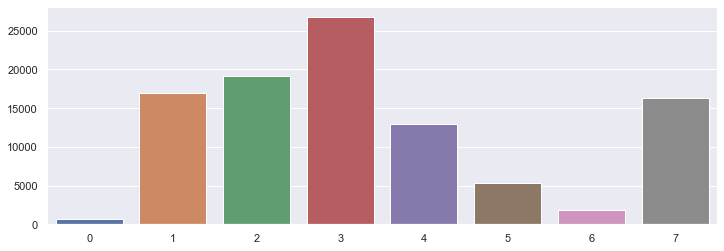

In [156]:
sns.barplot(x = df['delivery_days'].value_counts().index, y = df['delivery_days'].value_counts().values)

### 2.3 User specific Features
<a id="user_feat"></a>
Early visualization showed that the `user_id` might have an reasonable impact on wether or not an order will be returned. However, since the `user_id` differs for the known and unknown data set, we can not simply use the id as a feature. Therefore, we will have to engineer several features that are independent from the id itself.

In order to speed up the performance of the following functions, we first create a *dictionary* where each `user_id` gets assigned its corresponding unique *dataframe*.

In [157]:
user_known_dfs = {}
user_unknown_dfs = {}
for user_id in sorted(df['user_id'].unique()):
    user_df =  df.loc[df['user_id'] == user_id]
    user_known_dfs[user_id] = user_df
for user_id in sorted(df_unknown['user_id'].unique()):
    user_df =  df_unknown.loc[df_unknown['user_id'] == user_id]
    user_unknown_dfs[user_id] = user_df

#### 2.3.1 User account age at the time the order was placed
<a id="user_account_age"></a>

When cleaning the data we saw that many users ordered something before they registered for an account. Therefore, we will add an user_account_age in days where negative numbers indicate how many days after the order the user was registered. 

In [158]:
def calc_user_account_age(_df):
    user_account_age_ser = _df.apply(lambda x: (x['order_date'] - x['user_reg_date']).days, axis = 1)
    user_account_age_ser = cap_outliers(user_account_age_ser, verbose=True)
    user_account_age_ser = user_account_age_ser.astype(int)
    return user_account_age_ser

In [159]:
df['user_account_age'] = calc_user_account_age(df)
df_unknown['user_account_age'] = calc_user_account_age(df_unknown)

  Number of outliers:100000
Capping outliers by the IQR method:
   IQR threshold: 1.5
   Lower bound: -697.0
   Upper bound: 1223.0

  Number of outliers:50000
Capping outliers by the IQR method:
   IQR threshold: 1.5
   Lower bound: -878.0
   Upper bound: 1506.0



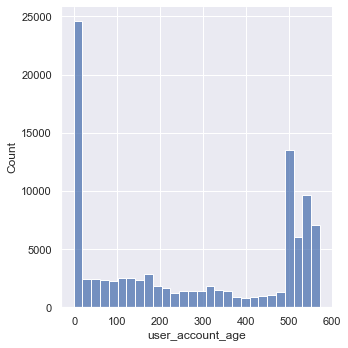

In [160]:
sns.displot(df['user_account_age'])

#### 2.3.2 User Age
<a id="user_age"></a>
Another interesting feature might be the age of an user at the time an order was placed. We simply substract the `user_dob` from the `order_date` and divide it by 365 to receive an user's age in years.

In [161]:
def calc_user_age(_df):
    # claculate age based on time of order
    user_age =_df.apply(lambda x: (x['order_date'] - x['user_dob']).days/365, axis = 1)
    user_age = user_age.astype(int)
    user_age = cap_outliers(user_age,verbose=True)
    return user_age

In [162]:
df['user_age'] = calc_user_age(df)
df_unknown['user_age'] = calc_user_age(df_unknown)

  Number of outliers:100000
Capping outliers by the IQR method:
   IQR threshold: 1.5
   Lower bound: 31.0
   Upper bound: 71.0

  Number of outliers:50000
Capping outliers by the IQR method:
   IQR threshold: 1.5
   Lower bound: 29.5
   Upper bound: 73.5



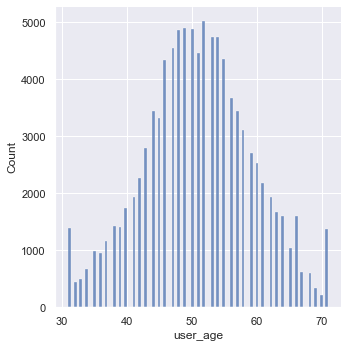

In [163]:
sns.displot(df['user_age'])

#### 2.3.3 Number of orders by user at order time
<a id="total_orders_by_user"></a>
To obtain the number of orders a user has placed at the date of an order we query the user's dataframe by the `user_id` and all `order_date`s that occured before the current date and count the number of rows left.

In [164]:
def calc_number_of_total_orders_by_user(_df, user_dfs):
    total_orders_by_user =_df.apply(
        lambda row: user_dfs[row['user_id']]['order_date'].where(
            user_dfs[row['user_id']]['order_date'] > row['order_date']).count() , axis = 1)
    total_orders_by_user = cap_outliers(total_orders_by_user)
    return total_orders_by_user

In [165]:
df['total_orders_by_user'] = calc_number_of_total_orders_by_user(df, user_known_dfs)
df_unknown['total_orders_by_user'] = calc_number_of_total_orders_by_user(df_unknown, user_unknown_dfs)

<AxesSubplot:>

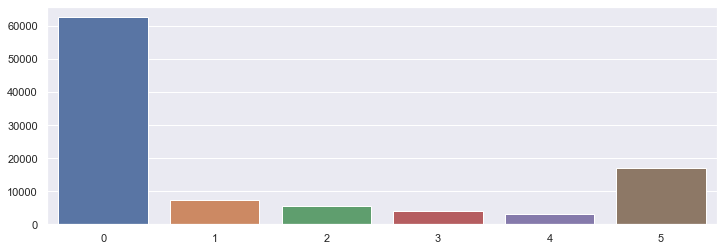

In [166]:
sns.barplot(x = df['total_orders_by_user'].value_counts().index, y = df['total_orders_by_user'].value_counts().values)

In [167]:
df['total_orders_by_user'].value_counts()

0    62670
5    17010
1     7335
2     5660
3     4108
4     3217
Name: total_orders_by_user, dtype: int64

#### 2.3.4 User has bought the same item before
<a id="has_bought_item_before"></a>
When a user has purchased an item in the past, it is likely that he/she knows that it will fit or that it fulfills his/her needs. Therefore we query the data by the `user_id` and the `item_id` and count the number of rows that are lower than the current `order_date`. If the number is greater than 0, the user has purchased the item before. If it is 0, the user never purchased the item.

In [168]:
def calc_has_bought_item_before(_df):
    has_bought_item_before = _df.apply(
        lambda row: len(_df[(_df['user_id'] == row['user_id']) \
                           & (_df['item_id'] == row['item_id']) \
                           & (_df['order_date']<row['order_date'])])!= 0
                            , axis=1)
    has_bought_item_before = has_bought_item_before.astype(int)
    return has_bought_item_before

In [169]:
df['has_bought_item_before'] = calc_has_bought_item_before(df)
df_unknown['has_bought_item_before'] = calc_has_bought_item_before(df_unknown)

<AxesSubplot:>

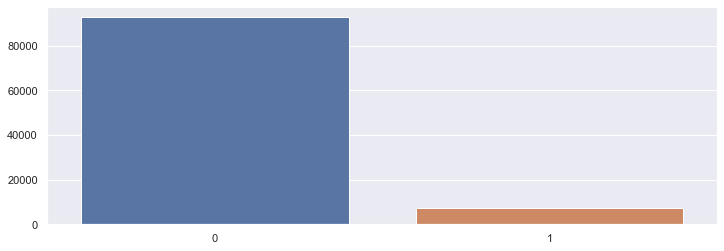

In [170]:
sns.barplot(x = df['has_bought_item_before'].value_counts().index, y = df['has_bought_item_before'].value_counts().values)

Only a small percentage of users buy an item that they have bought before. However maybe the return rate in these cases is significantly lower. We will explore this when visualizing the data. 

#### 2.3.5 User's first purchase
<a id="is_first_purchase"></a>
To engineer a feature which tells us whether or not an order was the first one a user ever made on our e-commerce platform, we simply query the data by the `user_id` check if the number of rows before the current `order_date` is equal to zero. If it is equal to zero, this is the user's first pruchase, otherwise the user has already made orders before. 

In [171]:
def calc_is_first_purchase(_df):
    number_of_purchases = _df.apply(
        lambda row: len(_df[(_df['user_id'] == row['user_id']) \
                         & (_df['order_date']< row['order_date'])]) == 0
                        , axis=1)
    number_of_purchases = number_of_purchases.astype(int)
    return number_of_purchases                                     
                                         

In [172]:
df['is_first_purchase'] = calc_is_first_purchase(df)
df_unknown['is_first_purchase'] = calc_is_first_purchase(df_unknown)

<AxesSubplot:>

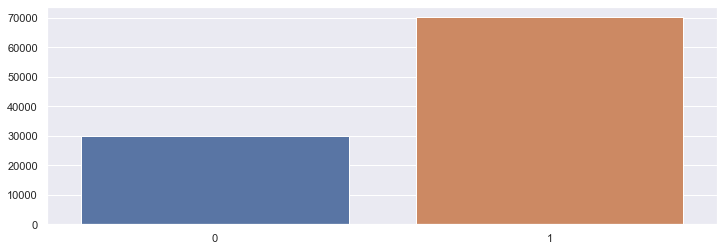

In [173]:
sns.barplot(x = df['is_first_purchase'].value_counts().index, y = df['is_first_purchase'].value_counts().values)

Roughly two thirds of all purchases were the user's first purchase in this shop.

#### 2.3.6 Number of items in order
<a id="number_of_items_in_order"></a>
While we don't have any direct information on how many items were orderd in one order, we can use the order_date to engineer this feature. While it could happen that a user places multiple orders on one day, one could argue that you could also sum this up to one order (e.g. forgot to order something)

In [174]:
def calc_number_of_items_in_order(_df):
    number_of_items_in_order = _df.apply(lambda row: len(_df[(_df['user_id'] == row['user_id']) & (_df['order_date'] == row['order_date'])]), axis = 1)
    return number_of_items_in_order

In [175]:
df['number_of_items_in_order'] = calc_number_of_items_in_order(df)
df_unknown['number_of_items_in_order'] = calc_number_of_items_in_order(df_unknown)

<AxesSubplot:>

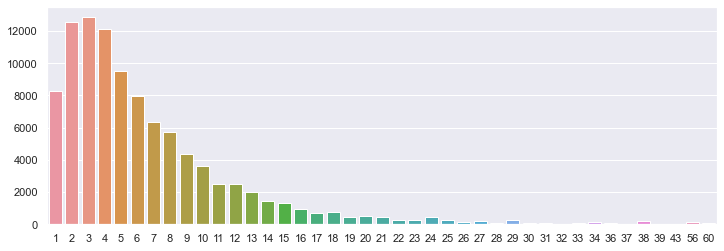

In [176]:

sns.barplot(x = df['number_of_items_in_order'].value_counts().index, y = df['number_of_items_in_order'].value_counts().values)

Most users only buy a couple of items a day when shopping at the online store. We will explore the return rates in correlation to the number of items in an order when visualzing the data.

#### 2.3.7 Ordered item at least twice in one order
<a id="ordered_item_multiple_times_in_order"></a>
When shopping for clothes and shoes online, users often order the same item multiple times in different sizes. Therefore, it might be useful to know if the ordered item was bought multiple times within an order. Below for example a user ordered the same item twice in different sizes. It is highly likely that at least one of those items will be sent back.

In [177]:
def calc_ordered_item_multiple_times_in_order(_df):
    ordered_item_multiple_times_in_order = _df.apply(
        lambda row: len(_df[(_df['order_date'] == row['order_date']) \
                            &(_df['user_id'] == row['user_id'])\
                            & (_df['item_id'] == row['item_id']) ]) > 1,
                            axis = 1)
    ordered_item_multiple_times_in_order = ordered_item_multiple_times_in_order.astype(int)
    return ordered_item_multiple_times_in_order

In [178]:
df['ordered_item_multiple_times_in_order'] = calc_ordered_item_multiple_times_in_order(df)
df_unknown['ordered_item_multiple_times_in_order'] = calc_ordered_item_multiple_times_in_order(df_unknown)

<AxesSubplot:>

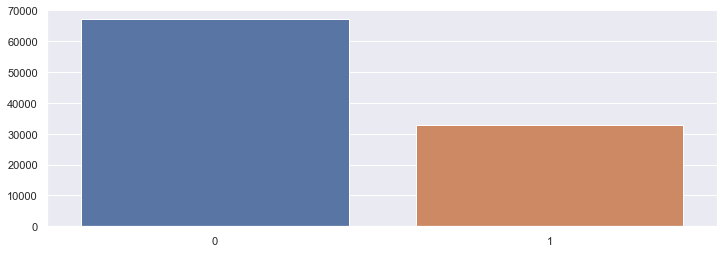

In [179]:
sns.barplot(x = df['ordered_item_multiple_times_in_order'].value_counts().index,
            y = df['ordered_item_multiple_times_in_order'].value_counts().values)

<AxesSubplot:>

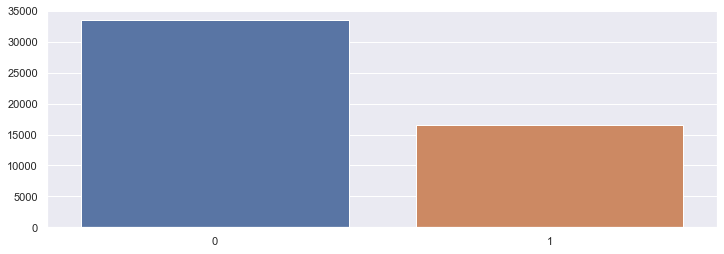

In [180]:
sns.barplot(x = df_unknown['ordered_item_multiple_times_in_order'].value_counts().index,
            y = df_unknown['ordered_item_multiple_times_in_order'].value_counts().values)

## 3 Feature Selection
<a id="feat_select"></a>
In this section we will try to come up with new features for independent variables with high cardinality. `item_id` and `brand_id` are a great example, since they have an enourmous number of features. I decided to use a woe binning approach in order to simoultaneously reduce the number of features for the variables while trying to keep most of the information value. 
I used a fairly new library called  <a href=https://github.com/guillermo-navas-palencia/optbinning>**OptBinning**</a> by *Guillermo Navas Palencia*. This library implements a rigorous and flexible mathematical programming formulation to solve the optimal binning problem for a binary, continuous and multiclass target type. One of its main benefits is that each bin has at least 5% of the total data entries in it, which avoids having bins with only a couple of values.


In [181]:
from optbinning import OptimalBinning

## 3.1 Unify Category Levels

Before binnin `item_id` and `brand_id`, we have to make sure that there are no cateogory level differences between the labelled and unlabelled dataset. The reason why we did not unify the category levels before like we did with `item_color` and `item_size` is that we needed the true values for some of previous feature engineering steps.

### 3.1.1 `item_id`
<a id="item_id"></a>

In [182]:
df['item_id'], df_unknown['item_id'] = unify_cat_levels([df['item_id'], df_unknown['item_id']])

Number of different Category Levels between datasets: 746
Series 1: values unified
Number of rows with diff category level: 10491
Series 2: values unified
Number of rows with diff category level: 1236


Here one can see that a lot of `item_id` values present in the known dataset are not in the unknown dataset. If these levels would have been kept in, algorithms could make errors in predictictions since they would assign weights to category levels that are not present in unknown / unlabelled data.  

### 3.1.1 `brand_id`
<a id="brand_id"></a>
As already discussed above in `item_color`, we will have to unify category levels for the `brand_id` values.

In [183]:
df['brand_id'], df_unknown['brand_id'] = unify_cat_levels([df['brand_id'], df_unknown['brand_id']])

Number of different Category Levels between datasets: 17
Series 1: values unified
Number of rows with diff category level: 105
Series 2: values unified
Number of rows with diff category level: 1


In [189]:
# change dtype back to category
df['brand_id'], df_unknown['brand_id']  = df['brand_id'].astype('category'), df_unknown['brand_id'].astype('category') 
df['item_id'], df_unknown['item_id']  = df['item_id'].astype('category'), df_unknown['item_id'].astype('category') 

## 3.2 Optimal Binning

To show how this binning technique works, we will try it out on `item_id`:

In [184]:
# function that takes in a variable and a target and returns an optp object 
def optimal_binning(col, y ):
    optb = OptimalBinning(dtype='categorical', solver='cp', max_n_prebins = 80)
    optb.fit(col.values, y.values)
    return optb

In [191]:
optimal_binning(df['item_id'], df['return']).binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[1118, 2054, 2055, 1417, 1125, 1323, 365, 667,...",5003,0.05003,4246,757,0.151309,1.5567,0.096272,0.010949
1,"[1909, 1519, 683, 87, 378, 1701, 271, 84, 1910...",6303,0.06303,4612,1691,0.268285,0.83567,0.040291,0.004895
2,"[696, 1806, 292, 211, 27, 1846, 1671, 447, 342...",5006,0.05006,3432,1574,0.314423,0.611851,0.017737,0.002183
3,"[2127, 1998, 2126, 2118, 1995, 1265, 168, 1975...",11373,0.11373,7550,3823,0.336147,0.51284,0.028671,0.003545
4,"[343, 750, 984, 1520, 1792, 257, 1743, 2019, 1...",6665,0.06665,4238,2427,0.364141,0.389764,0.009841,0.001222
5,"[625, 121, 223, 1512, 1604, 1525, 1476, 328, 1...",7487,0.07487,4523,2964,0.395886,0.254964,0.004790,0.000597
6,"[2170, 1548, 367, 126, 70, 1359, 1681, 427, 16...",7451,0.07451,4201,3250,0.436183,0.0889959,0.000588,0.000073
7,"[41, 1879, 774, 488, 512, 1477, 1139, 2099, 20...",7179,0.07179,3775,3404,0.474161,-0.0642226,0.000297,0.000037
8,"[1485, 1647, 14, 86, 1556, 151, 1790, 2140, 45...",8448,0.08448,4134,4314,0.510653,-0.210292,0.003755,0.000469
9,"[454, 1598, 163, 268, 1913, 1510, 1645, 1861, ...",9268,0.09268,4220,5048,0.544670,-0.346829,0.011199,0.001393


Above we can see that the algorithm binned the features `item_id` into 13 distinct bins, while making sure each bin is at least 5% of the total data entries. This table also gives some information about the different WOE of certain groups, indicating that some item groups have substantially more influence on our dependent `return` variable.
We will now create binning groups features based on their WOE for:
- `item_id`
- `brand_id`
- `item_color`
- `item_size`

In [192]:
#columns for which we want to calculate woe_bins 
woe_cols = ['item_id','brand_id','item_color','item_size']

for col in woe_cols:
    optb = optimal_binning(df[col], df['return'])
    print(f'Status of Binning: {optb.status}')
    # use the inbuilt transform func of optb to automatically assign a binning group according to the woe value
    df[col+'_group'] = optb.transform(df[col], metric='indices')
    
    # transform unknown dataset cols
    df_unknown[col+'_group'] = optb.transform(df_unknown[col], metric='indices')
    
    #Change Dtypes
    df[col+'_group'] = df[col+'_group'].astype('category') 
    df_unknown[col+'_group'] = df_unknown[col+'_group'].astype('category') 
    
    #Save Bin Mapping in dict
    opt_b_df = optb.binning_table.build()
    bin_dict = {}
    for index, row in opt_b_df.iterrows():
        bin_dict[index] = list(row[0])
    
    #Save as JSON
    with open(f'../data/03_processed/{col}_bin_map.json', 'w') as fp:
        json.dump(bin_dict, fp)

Status of Binning: OPTIMAL
Status of Binning: OPTIMAL
Status of Binning: OPTIMAL
Status of Binning: OPTIMAL


We will explore the different binning groups when exploring the data.

## 4. Save Processed Data
<a id="export"></a>

In [193]:
# Sanity check
print('\n================================> KOWN DF <=====================================')
df.info()
print('\n================================> UNKOWN DF <=====================================')
df_unknown.info()


================================> KOWN DF <=====================================
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100001 to 200000
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   order_date                            100000 non-null  datetime64[ns]
 1   delivery_date                         100000 non-null  datetime64[ns]
 2   item_id                               100000 non-null  category      
 3   item_size                             100000 non-null  category      
 4   item_color                            100000 non-null  category      
 5   brand_id                              100000 non-null  category      
 6   item_price                            100000 non-null  float32       
 7   user_id                               100000 non-null  category      
 8   user_title                            100000 no

In [194]:
#Sanity #2: check to see if both df's have the same number of columns
(len(df.columns)-1 == len(df_unknown.columns) ) & (len(df.columns)-1 == len(df_unknown.columns))

True

In [195]:
# Save processed data with all feutures
df.to_pickle('../data/03_processed/BADS_WS2021_known_processed_all_cols.pkl')
df_unknown.to_pickle('../data/03_processed/BADS_WS2021_unknown_processed_all_cols.pkl')